In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import io
from torch.utils.data import Dataset, DataLoader
from torch import nn
pd.set_option("display.max_columns", 101)
pd.set_option('display.max_colwidth', 100)

In [2]:
data = pd.read_csv('train.csv')
data.head()

,path,label
0,train/0.jpg,1
1,train/1.jpg,1
2,train/2.jpg,0
3,train/3.jpg,0
4,train/4.jpg,0


In [3]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)

In [4]:
data_test = pd.read_csv('test.csv')

In [133]:
class TrafficSignsDataset(Dataset):
    def __init__(self, annotations_file, transforms, image_dir):
        self.transforms = transforms
        self.image_labels = annotations_file
        self.img_dir = image_dir

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_labels.iloc[idx, 0])
        image = io.read_image(img_path).float() / 255.0
        label = self.image_labels.iloc[idx, 1]
        if self.transforms:
            image = self.transforms(image)
        return image, label


In [134]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32,32)),
        # torchvision.transforms.RandomRotation(30),
        # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32,32)),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [135]:
dataset_train = TrafficSignsDataset(data_train, train_transforms, os.getcwd())
dataset_validate = TrafficSignsDataset(data_val, train_transforms, os.getcwd())
dataset_test = TrafficSignsDataset(data_test, test_transforms, os.getcwd())

In [136]:
def plot_image(dataset, indice):
    image_tensor, label = dataset[indice]
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_denorm = image_tensor * std + mean
    image_denorm = torch.clamp(image_denorm, 0, 1)
    image_np = image_denorm.permute(1, 2, 0).numpy()
    plt.xlabel(label)
    plt.imshow(image_np)

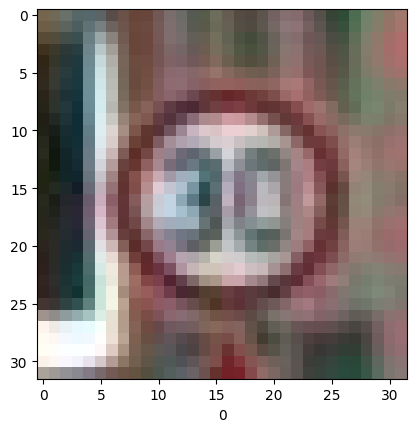

In [137]:
plot_image(dataset_train, 11)

In [138]:
train_loader = DataLoader(dataset_train, 32, shuffle=True)

In [139]:
class Model(nn.Module):
    def __init__(self, device):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.LeakyReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fn1 = nn.Linear(128*4*4, 512)
        self.act4 = nn.LeakyReLU()
        self.fn2 = nn.Linear(512,3)

        if device.type == "cuda":
            self.cuda()

    def forward(self, x):
        x = self.pool(self.act1(self.bn1(self.conv1(x))))
        x = self.pool(self.act2(self.bn2(self.conv2(x))))
        x = self.pool(self.act3(self.bn3(self.conv3(x))))
        x = self.act4(self.fn1(self.flatten(x)))
        x = self.fn2(x)
        return x


In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(device)

In [141]:
def train(epochs, model, data, device, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for image, label in data:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}, loss: {loss}")


In [142]:
train(10, model, train_loader, device)

Epoch: 0, loss: 0.049630556255578995
Epoch: 1, loss: 0.005187375005334616
Epoch: 2, loss: 0.00022348678612615913
Epoch: 3, loss: 0.0001394866849295795
Epoch: 4, loss: 0.0002552198711782694
Epoch: 5, loss: 0.007959705777466297
Epoch: 6, loss: 1.9868208767093165e-07
Epoch: 7, loss: 0.0005050649051554501
Epoch: 8, loss: 3.95751376345288e-05
Epoch: 9, loss: 1.3510358485291363e-06


In [ ]:
def batch_overfit(model, loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    batch = next(iter(loader))
    image, label = batch
    prev_loss = 19
    for epoch in range(epochs):
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            print(f"Epoch: {epoch}, loss: {loss}")
batch_overfit(model, train_loader, 100)

Epoch: 0, loss: 0.14607274532318115
Epoch: 1, loss: 0.03921637311577797
Epoch: 2, loss: 0.035821788012981415
Epoch: 3, loss: 0.01080948393791914
Epoch: 4, loss: 0.002860873471945524
Epoch: 5, loss: 0.0010215495713055134
Epoch: 6, loss: 0.0005006020073778927
Epoch: 7, loss: 0.0003149414842482656
Epoch: 8, loss: 0.00022859965974930674
Epoch: 9, loss: 0.00017608811322133988
Epoch: 10, loss: 0.00013908781693316996
Epoch: 11, loss: 0.00011414493201300502
Epoch: 12, loss: 9.607165702618659e-05
Epoch: 13, loss: 8.178207644959912e-05
Epoch: 14, loss: 7.076460315147415e-05
Epoch: 15, loss: 6.205679528648034e-05
Epoch: 16, loss: 5.516421515494585e-05
Epoch: 17, loss: 4.9391415814170614e-05
Epoch: 18, loss: 4.4835334847448394e-05
Epoch: 19, loss: 4.103467654203996e-05
Epoch: 20, loss: 3.77736178052146e-05
Epoch: 21, loss: 3.4951677662320435e-05
Epoch: 22, loss: 3.250563531764783e-05
Epoch: 23, loss: 3.039084913325496e-05
Epoch: 24, loss: 2.8570135327754542e-05
Epoch: 25, loss: 2.6991383492713794e